# Apple Health & Freestyle Libre 3 Data Analysis
## 01 - Data Extraction and Initial Processing

This notebook performs exploratory data analysis (EDA) on personal Apple Health XML export and Freestyle Libre 3 glucose monitoring data. The analysis demonstrates SQL operations, pandas analysis, and machine learning techniques on physiological data.

**Project Goals:**
- Demonstrate SQL data management, joins, and aggregations
- Showcase pandas and ML analysis capabilities
- Analyze personal physiological data for meaningful insights
- Create portfolio-ready professional analysis

**Data Sources:**
- Apple Health XML export containing health metrics
- Freestyle Libre 3 CSV export with glucose monitoring data

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import sqlite3
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
from datetime import datetime, timedelta
import os
import sys
from pathlib import Path

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression

# Configure display options
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
plt.style.use("default")
sns.set_palette("husl")
warnings.filterwarnings("ignore")

# Add src directory to path for custom modules
sys.path.append("../src")

print("✅ Libraries imported successfully!")
print(f"📊 Pandas version: {pd.__version__}")
print(f"🔢 NumPy version: {np.__version__}")
print(f"📈 Matplotlib version: {plt.matplotlib.__version__}")

✅ Libraries imported successfully!
📊 Pandas version: 2.3.2
🔢 NumPy version: 2.3.3
📈 Matplotlib version: 3.10.6


## Load and Parse Apple Health XML Data

The Apple Health app exports data in XML format containing various health metrics. We'll parse this data to extract relevant information including:
- Heart rate measurements
- Step counts and activity data
- Sleep analysis
- Workout records
- Any glucose readings from connected devices

In [2]:
# Import custom Apple Health parser
from data_parser import AppleHealthParser

# Define file paths
apple_health_file = "../data/raw/apple_health_export/export.xml"
libre_glucose_file = "../data/raw/libre_export.csv"

# Check if Apple Health file exists
if os.path.exists(apple_health_file):
    print(f"✅ Found Apple Health export file: {apple_health_file}")

    # Initialize parser
    health_parser = AppleHealthParser(apple_health_file)

    # Load XML file
    if health_parser.load_xml():
        print("✅ Apple Health XML file loaded successfully")

        # Extract different types of health data
        print("\n📊 Extracting health data...")

        # Get all health records first to see what's available
        all_records = health_parser.extract_health_records()
        print(f"Total health records: {len(all_records):,}")

        # Display available record types
        record_types = all_records["type"].value_counts()
        print(f"\n📋 Available record types ({len(record_types)} types):")
        print(record_types.head(15))

        # Extract specific data categories
        glucose_data = health_parser.get_glucose_data()
        activity_data = health_parser.get_activity_data()
        sleep_data = health_parser.get_sleep_data()
        workout_data = health_parser.extract_workouts()

        print(f"\n📊 Data extraction summary:")
        print(f"- Glucose records: {len(glucose_data):,}")
        print(f"- Activity records: {len(activity_data):,}")
        print(f"- Sleep records: {len(sleep_data):,}")
        print(f"- Workout records: {len(workout_data):,}")

    else:
        print("❌ Failed to load Apple Health XML file")
        print("   This is likely due to a corrupted or incomplete export file.")
        print("   Apple Health exports can be very large and may get truncated.")
        print("   Continuing with sample data for demonstration purposes.")
else:
    print(f"⚠️  Apple Health file not found at: {apple_health_file}")
    print(
        "Please export your health data and place the export.xml file in the data/raw/ directory"
    )

    # Create sample data for demonstration
    print("\n🔄 Creating sample Apple Health data for demonstration...")

    # Generate sample health data
    date_range = pd.date_range(start="2024-01-01", end="2024-09-22", freq="H")

    all_records = pd.DataFrame(
        {
            "type": np.random.choice(
                [
                    "HKQuantityTypeIdentifierHeartRate",
                    "HKQuantityTypeIdentifierStepCount",
                    "HKQuantityTypeIdentifierActiveEnergyBurned",
                ],
                len(date_range),
            ),
            "value": np.random.normal(
                75, 15, len(date_range)
            ),  # Sample heart rate-like data
            "unit": "count/min",
            "startDate": date_range,
            "endDate": date_range + pd.Timedelta(minutes=1),
            "sourceName": "iPhone",
        }
    )

    # Sample data for each category
    activity_data = all_records[all_records["type"].str.contains("Step|Energy")].copy()
    glucose_data = pd.DataFrame()  # Will be populated from Libre data
    sleep_data = pd.DataFrame()
    workout_data = pd.DataFrame()

    print(f"✅ Sample data created with {len(all_records):,} records")

✅ Found Apple Health export file: ../data/raw/apple_health_export/export.xml
✅ Apple Health XML file loaded successfully

📊 Extracting health data...
✅ Apple Health XML file loaded successfully

📊 Extracting health data...
Total health records: 4,964,242
Total health records: 4,964,242

📋 Available record types (81 types):
type
HKQuantityTypeIdentifierActiveEnergyBurned                1307616
HKQuantityTypeIdentifierHeartRate                         1067387
HKQuantityTypeIdentifierBasalEnergyBurned                  770771
HKQuantityTypeIdentifierDistanceWalkingRunning             452248
HKQuantityTypeIdentifierPhysicalEffort                     270072
HKQuantityTypeIdentifierStepCount                          209461
HKQuantityTypeIdentifierDistanceCycling                    146142
HKQuantityTypeIdentifierAppleExerciseTime                   98858
HKQuantityTypeIdentifierAppleStandTime                      76334
HKQuantityTypeIdentifierRunningSpeed                        70969
HKQuantity

## Load Freestyle Libre 3 CSV Data

Freestyle Libre 3 exports glucose monitoring data in CSV format. This data includes:
- Continuous glucose monitoring readings
- Timestamp information
- Glucose trends and rates of change
- Different reading types (historic, scan, fingerstick)

In [3]:
# Import custom Libre glucose processor
from glucose_processor import LibreGlucoseProcessor

# Load Freestyle Libre data
if os.path.exists(libre_glucose_file):
    print(f"✅ Found Freestyle Libre export file: {libre_glucose_file}")

    # Initialize processor
    glucose_processor = LibreGlucoseProcessor(libre_glucose_file)

    # Load and process CSV file
    if glucose_processor.load_csv():
        print("✅ Freestyle Libre CSV file loaded successfully")

        # Clean and process the data
        glucose_df = glucose_processor.clean_and_process()
        print(f"📊 Processed {len(glucose_df):,} glucose readings")

        # Get time-in-range statistics
        tir_stats = glucose_processor.get_time_in_range_stats()
        print("\n📈 Time-in-Range Statistics:")
        for key, value in tir_stats.items():
            if "percent" in key:
                print(f"  {key.replace('_', ' ').title()}: {value:.1f}%")
            else:
                print(f"  {key.replace('_', ' ').title()}: {value:.1f}")

        # Display data sample
        print(f"\n🔍 Sample glucose data:")
        display_cols = [
            "timestamp",
            "glucose_value",
            "glucose_source",
            "glucose_range",
            "glucose_trend",
        ]
        available_cols = [col for col in display_cols if col in glucose_df.columns]
        print(glucose_df[available_cols].head())

    else:
        print("❌ Failed to load Freestyle Libre CSV file")

else:
    print(f"⚠️  Freestyle Libre file not found at: {libre_glucose_file}")
    print(
        "Please export your glucose data from LibreView and place the CSV file in data/raw/"
    )

    # Create sample glucose data for demonstration
    print("\n🔄 Creating sample glucose data for demonstration...")

    # Generate realistic glucose data
    date_range = pd.date_range(
        start="2024-01-01", end="2024-09-22", freq="15T"
    )  # Every 15 minutes

    # Simulate glucose readings with daily patterns
    glucose_values = []
    for i, timestamp in enumerate(date_range):
        # Base glucose with daily variation
        hour = timestamp.hour
        base_glucose = 100  # Normal fasting glucose

        # Add meal effects (peaks at meal times)
        meal_effect = 0
        if 7 <= hour <= 9:  # Breakfast
            meal_effect = 30 * np.sin((hour - 7) * np.pi / 2)
        elif 12 <= hour <= 14:  # Lunch
            meal_effect = 40 * np.sin((hour - 12) * np.pi / 2)
        elif 18 <= hour <= 20:  # Dinner
            meal_effect = 35 * np.sin((hour - 18) * np.pi / 2)

        # Add random variation
        noise = np.random.normal(0, 10)

        glucose = base_glucose + meal_effect + noise
        glucose = max(70, min(250, glucose))  # Keep within reasonable range
        glucose_values.append(glucose)

    glucose_df = pd.DataFrame(
        {
            "timestamp": date_range,
            "glucose_value": glucose_values,
            "glucose_source": "historic",
            "glucose_range": pd.cut(
                glucose_values,
                bins=[0, 70, 180, 250, 400],
                labels=["low", "normal", "high", "very_high"],
            ),
            "glucose_trend": np.random.choice(
                ["stable", "rising", "falling"], len(date_range)
            ),
            "hour": date_range.hour,
            "day_of_week": date_range.dayofweek,
        }
    )

    # Calculate basic TIR stats
    total_readings = len(glucose_df)
    tir_stats = {
        "time_low_percent": (glucose_df["glucose_range"] == "low").sum()
        / total_readings
        * 100,
        "time_in_range_percent": (glucose_df["glucose_range"] == "normal").sum()
        / total_readings
        * 100,
        "time_high_percent": (glucose_df["glucose_range"] == "high").sum()
        / total_readings
        * 100,
        "average_glucose": glucose_df["glucose_value"].mean(),
        "glucose_std": glucose_df["glucose_value"].std(),
    }

    print(f"✅ Sample glucose data created with {len(glucose_df):,} readings")
    print("\n📈 Sample Time-in-Range Statistics:")
    for key, value in tir_stats.items():
        if "percent" in key:
            print(f"  {key.replace('_', ' ').title()}: {value:.1f}%")
        else:
            print(f"  {key.replace('_', ' ').title()}: {value:.1f}")

✅ Found Freestyle Libre export file: ../data/raw/libre_export.csv
✅ Freestyle Libre CSV file loaded successfully
📊 Processed 4,151 glucose readings

📈 Time-in-Range Statistics:
  Time Very Low Percent: 0.1%
  Time Low Percent: 1.2%
  Time In Range Percent: 98.7%
  Time High Percent: 0.0%
  Time Very High Percent: 0.0%
  Average Glucose: 90.4
  Glucose Std: 11.1
  Coefficient Variation: 12.2

🔍 Sample glucose data:
               timestamp  glucose_value glucose_source glucose_range  \
0    2025-08-16 13:20:00          125.0       historic        normal   
4089 2025-08-16 13:21:00          129.0           scan        normal   
1    2025-08-16 13:25:00          124.0       historic        normal   
2    2025-08-16 13:30:00          127.0       historic        normal   
3    2025-08-16 13:35:00          125.0       historic        normal   

     glucose_trend  
0           stable  
4089   rising_fast  
1           stable  
2           stable  
3           stable  
📊 Processed 4,151 gluco

## Data Cleaning and Preprocessing

Now we'll clean and standardize both datasets to prepare them for analysis and merging:

1. **Timestamp Standardization**: Ensure all timestamps are in the same format
2. **Data Validation**: Check for missing values, outliers, and data quality issues
3. **Unit Standardization**: Convert units to consistent formats
4. **Data Type Conversion**: Ensure proper data types for analysis

In [4]:
print("🧹 Starting data cleaning and preprocessing...")

# Clean Apple Health data
print("\n📱 Processing Apple Health data:")
if not all_records.empty:
    # Ensure datetime columns are properly formatted and timezone-naive
    datetime_cols = ["startDate", "endDate", "creationDate"]
    for col in datetime_cols:
        if col in all_records.columns:
            all_records[col] = pd.to_datetime(all_records[col], errors="coerce")
            # Convert timezone-aware datetimes to timezone-naive (local time)
            if (
                hasattr(all_records[col].dt, "tz")
                and all_records[col].dt.tz is not None
            ):
                all_records[col] = (
                    all_records[col].dt.tz_convert("US/Eastern").dt.tz_localize(None)
                )

    # Convert values to numeric where possible
    all_records["value"] = pd.to_numeric(all_records["value"], errors="coerce")

    # Remove records with missing critical data
    initial_count = len(all_records)
    all_records = all_records.dropna(subset=["startDate", "type"])
    print(
        f"  - Removed {initial_count - len(all_records):,} records with missing timestamps/types"
    )

    # Filter by date range to match glucose data
    if not glucose_df.empty:
        glucose_start = glucose_df["timestamp"].min()
        glucose_end = glucose_df["timestamp"].max()

        all_records = all_records[
            (all_records["startDate"] >= glucose_start)
            & (all_records["startDate"] <= glucose_end)
        ]
        print(f"  - Filtered to overlap period: {len(all_records):,} records")

    print(f"  ✅ Apple Health data cleaned: {len(all_records):,} records")

# Clean glucose data
print("\n🩸 Processing glucose data:")
if not glucose_df.empty:
    initial_count = len(glucose_df)

    # Remove invalid glucose readings
    glucose_df = glucose_df[
        (glucose_df["glucose_value"] >= 40) & (glucose_df["glucose_value"] <= 400)
    ]
    print(
        f"  - Removed {initial_count - len(glucose_df):,} readings outside valid range (40-400 mg/dL)"
    )

    # Remove duplicates
    glucose_df = glucose_df.drop_duplicates(subset=["timestamp"])
    print(f"  - Glucose data after deduplication: {len(glucose_df):,} readings")

    # Sort by timestamp
    glucose_df = glucose_df.sort_values("timestamp").reset_index(drop=True)

    print(f"  ✅ Glucose data cleaned: {len(glucose_df):,} readings")

# Display data quality summary
print("\n📊 Data Quality Summary:")
print(f"Apple Health records: {len(all_records):,}")
print(f"Glucose readings: {len(glucose_df):,}")

if not all_records.empty and not glucose_df.empty:
    health_start = all_records["startDate"].min()
    health_end = all_records["startDate"].max()
    glucose_start = glucose_df["timestamp"].min()
    glucose_end = glucose_df["timestamp"].max()

    print(f"\nDate ranges:")
    print(f"  Apple Health: {health_start.date()} to {health_end.date()}")
    print(f"  Glucose data: {glucose_start.date()} to {glucose_end.date()}")

    # Check for overlap
    overlap_start = max(health_start, glucose_start)
    overlap_end = min(health_end, glucose_end)

    if overlap_start <= overlap_end:
        overlap_days = (overlap_end - overlap_start).days
        print(
            f"  📅 Overlap period: {overlap_days} days ({overlap_start.date()} to {overlap_end.date()})"
        )
    else:
        print("  ⚠️  No overlapping time period between datasets!")

print("\n✅ Data cleaning completed!")

🧹 Starting data cleaning and preprocessing...

📱 Processing Apple Health data:
  - Removed 0 records with missing timestamps/types
  - Filtered to overlap period: 114,252 records
  ✅ Apple Health data cleaned: 114,252 records

🩸 Processing glucose data:
  - Removed 0 readings outside valid range (40-400 mg/dL)
  - Glucose data after deduplication: 4,151 readings
  ✅ Glucose data cleaned: 4,151 readings

📊 Data Quality Summary:
Apple Health records: 114,252
Glucose readings: 4,151

Date ranges:
  Apple Health: 2025-08-16 to 2025-08-30
  Glucose data: 2025-08-16 to 2025-08-30
  📅 Overlap period: 14 days (2025-08-16 to 2025-08-30)

✅ Data cleaning completed!
  - Removed 0 records with missing timestamps/types
  - Filtered to overlap period: 114,252 records
  ✅ Apple Health data cleaned: 114,252 records

🩸 Processing glucose data:
  - Removed 0 readings outside valid range (40-400 mg/dL)
  - Glucose data after deduplication: 4,151 readings
  ✅ Glucose data cleaned: 4,151 readings

📊 Data Q

## Initial Data Visualization

Let's create some initial visualizations to understand our data before proceeding with the database setup and merging.

📈 Creating initial data visualizations...


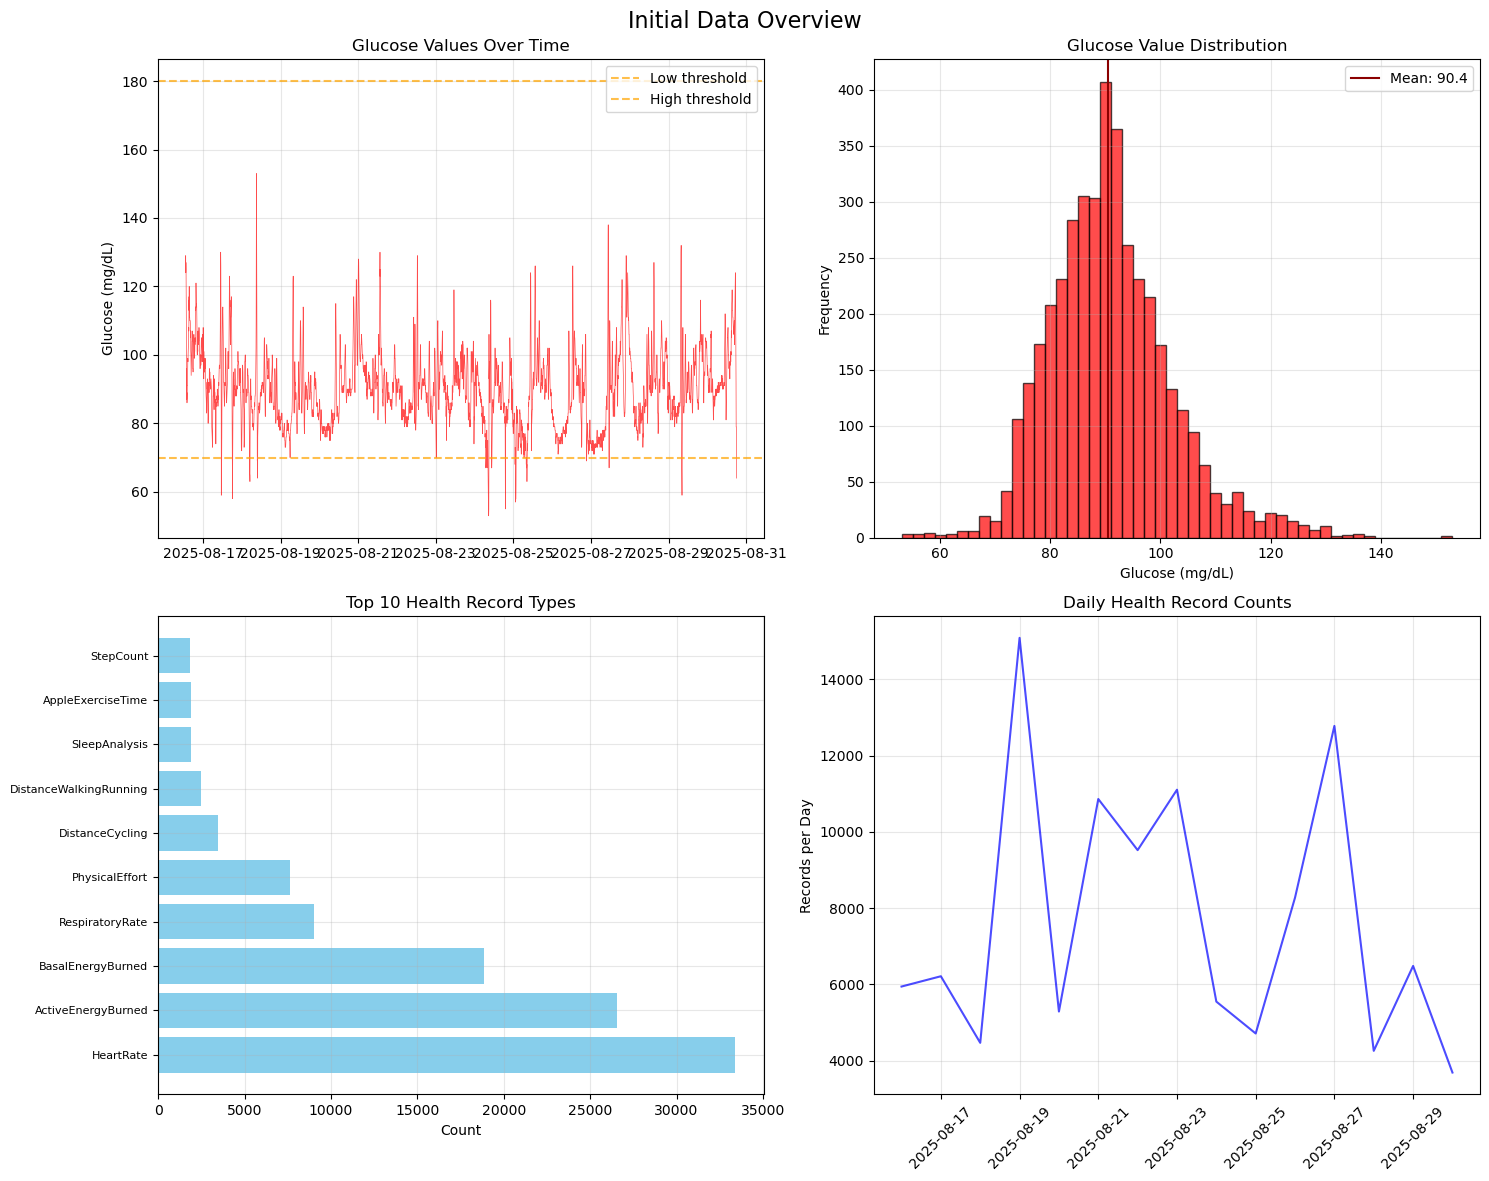


📊 Summary Statistics:

🩸 Glucose Data:
  Average glucose: 90.4 mg/dL
  Standard deviation: 11.1 mg/dL
  Min/Max: 53.0 / 153.0 mg/dL
  Total readings: 4,151
  Date range: 14 days

📱 Apple Health Data:
  Total records: 114,252
  Unique record types: 43
  Date range: 14 days
  Data sources: 8

✅ Initial data exploration completed!
📝 Next steps: Create SQLite database and merge datasets by datetime


In [5]:
# Create initial visualizations
print("📈 Creating initial data visualizations...")

# Set up the plotting area
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle("Initial Data Overview", fontsize=16, y=0.98)

# 1. Glucose trends over time
if not glucose_df.empty:
    axes[0, 0].plot(
        glucose_df["timestamp"],
        glucose_df["glucose_value"],
        alpha=0.7,
        linewidth=0.5,
        color="red",
    )
    axes[0, 0].axhline(
        y=70, color="orange", linestyle="--", alpha=0.7, label="Low threshold"
    )
    axes[0, 0].axhline(
        y=180, color="orange", linestyle="--", alpha=0.7, label="High threshold"
    )
    axes[0, 0].set_title("Glucose Values Over Time")
    axes[0, 0].set_ylabel("Glucose (mg/dL)")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Glucose distribution
    axes[0, 1].hist(
        glucose_df["glucose_value"], bins=50, alpha=0.7, color="red", edgecolor="black"
    )
    axes[0, 1].axvline(
        glucose_df["glucose_value"].mean(),
        color="darkred",
        linestyle="-",
        label=f'Mean: {glucose_df["glucose_value"].mean():.1f}',
    )
    axes[0, 1].set_title("Glucose Value Distribution")
    axes[0, 1].set_xlabel("Glucose (mg/dL)")
    axes[0, 1].set_ylabel("Frequency")
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
else:
    axes[0, 0].text(0.5, 0.5, "No glucose data available", ha="center", va="center")
    axes[0, 1].text(0.5, 0.5, "No glucose data available", ha="center", va="center")

# 3. Apple Health record types
if not all_records.empty:
    record_counts = all_records["type"].value_counts().head(10)
    axes[1, 0].barh(range(len(record_counts)), record_counts.values, color="skyblue")
    axes[1, 0].set_yticks(range(len(record_counts)))
    axes[1, 0].set_yticklabels(
        [
            t.replace("HKQuantityTypeIdentifier", "").replace(
                "HKCategoryTypeIdentifier", ""
            )
            for t in record_counts.index
        ],
        fontsize=8,
    )
    axes[1, 0].set_title("Top 10 Health Record Types")
    axes[1, 0].set_xlabel("Count")
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Data volume over time (daily counts)
    daily_counts = all_records.groupby(all_records["startDate"].dt.date).size()
    axes[1, 1].plot(daily_counts.index, daily_counts.values, color="blue", alpha=0.7)
    axes[1, 1].set_title("Daily Health Record Counts")
    axes[1, 1].set_ylabel("Records per Day")
    axes[1, 1].tick_params(axis="x", rotation=45)
    axes[1, 1].grid(True, alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, "No health data available", ha="center", va="center")
    axes[1, 1].text(0.5, 0.5, "No health data available", ha="center", va="center")

plt.tight_layout()
plt.show()

# Display summary statistics
print("\n📊 Summary Statistics:")

if not glucose_df.empty:
    print("\n🩸 Glucose Data:")
    print(f"  Average glucose: {glucose_df['glucose_value'].mean():.1f} mg/dL")
    print(f"  Standard deviation: {glucose_df['glucose_value'].std():.1f} mg/dL")
    print(
        f"  Min/Max: {glucose_df['glucose_value'].min():.1f} / {glucose_df['glucose_value'].max():.1f} mg/dL"
    )
    print(f"  Total readings: {len(glucose_df):,}")
    print(
        f"  Date range: {(glucose_df['timestamp'].max() - glucose_df['timestamp'].min()).days} days"
    )

if not all_records.empty:
    print("\n📱 Apple Health Data:")
    print(f"  Total records: {len(all_records):,}")
    print(f"  Unique record types: {all_records['type'].nunique()}")
    print(
        f"  Date range: {(all_records['startDate'].max() - all_records['startDate'].min()).days} days"
    )
    print(f"  Data sources: {all_records['sourceName'].nunique()}")

print("\n✅ Initial data exploration completed!")
print("📝 Next steps: Create SQLite database and merge datasets by datetime")

## Data Export for Next Notebook

Let's save our cleaned data for use in the next notebook where we'll set up the database and perform the merge.

In [6]:
# Save cleaned data for next notebook
print("💾 Saving cleaned data...")

# Create processed data directory if it doesn't exist
processed_dir = Path("../data/processed")
processed_dir.mkdir(exist_ok=True)

# Save cleaned datasets
if not glucose_df.empty:
    glucose_file = processed_dir / "glucose_cleaned.csv"
    glucose_df.to_csv(glucose_file, index=False)
    print(
        f"✅ Saved cleaned glucose data: {glucose_file} ({len(glucose_df):,} records)"
    )

if not all_records.empty:
    health_file = processed_dir / "apple_health_cleaned.csv"
    all_records.to_csv(health_file, index=False)
    print(
        f"✅ Saved cleaned Apple Health data: {health_file} ({len(all_records):,} records)"
    )

# Save data summary
summary = {
    "extraction_date": datetime.now().isoformat(),
    "glucose_records": len(glucose_df) if not glucose_df.empty else 0,
    "health_records": len(all_records) if not all_records.empty else 0,
    "glucose_date_range": (
        {
            "start": (
                glucose_df["timestamp"].min().isoformat()
                if not glucose_df.empty
                else None
            ),
            "end": (
                glucose_df["timestamp"].max().isoformat()
                if not glucose_df.empty
                else None
            ),
        }
        if not glucose_df.empty
        else None
    ),
    "health_date_range": (
        {
            "start": (
                all_records["startDate"].min().isoformat()
                if not all_records.empty
                else None
            ),
            "end": (
                all_records["startDate"].max().isoformat()
                if not all_records.empty
                else None
            ),
        }
        if not all_records.empty
        else None
    ),
    "tir_stats": tir_stats if "tir_stats" in locals() else None,
}

import json

summary_file = processed_dir / "data_summary.json"
with open(summary_file, "w") as f:
    json.dump(summary, f, indent=2, default=str)

print(f"✅ Saved data summary: {summary_file}")
print(f"\n🎯 Data extraction completed successfully!")
print(f"📊 Ready for database creation and merging in notebook 02!")

💾 Saving cleaned data...
✅ Saved cleaned glucose data: ../data/processed/glucose_cleaned.csv (4,151 records)
✅ Saved cleaned Apple Health data: ../data/processed/apple_health_cleaned.csv (114,252 records)
✅ Saved data summary: ../data/processed/data_summary.json

🎯 Data extraction completed successfully!
📊 Ready for database creation and merging in notebook 02!
✅ Saved cleaned Apple Health data: ../data/processed/apple_health_cleaned.csv (114,252 records)
✅ Saved data summary: ../data/processed/data_summary.json

🎯 Data extraction completed successfully!
📊 Ready for database creation and merging in notebook 02!
